In [3]:
import numpy as np
import pandas as pd

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# 0. Inicializando Ambiente Django no Notebook

Por enquanto não estou utilizando os dados do banco de dados (e sim o csv presente em csv_data/).

Porém no dia 21/05/25 modifiquei o django_for_jupyter.py para que após a reestruturação dos diretórios os notebooks antigos (e também os dentro de classification) possam acessar o BD futuramente.

In [4]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

from django_for_jupyter import init_django
init_django('app')

Django initialized for project: app
Project root added to sys.path: /home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator


# 1. Load do CSV

In [5]:
notebook_dir = os.getcwd()
csv_file_path = os.path.join(notebook_dir, '..', '..', 'csv_data', 'processed', 'pgm-dataset_clean.csv')
print(f'Caminho do CSV: {csv_file_path}')

df = pd.read_csv(csv_file_path)

Caminho do CSV: /home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator/notebooks/classification/../../csv_data/processed/pgm-dataset_clean.csv


In [6]:
# Verificando quantos exemplos do APOIO FISCAL nós temos

print('No DataFrame para temos:\n')
for classe, qtd in Counter(df['setorDestino']).most_common():
    dataframe_size = len(df)
    print(f'{classe:<50}: {qtd:<5} textos ou {(qtd/dataframe_size*100):.2f}% do Dataframe')

No DataFrame para temos:

Procuradoria Administrativa                       : 4607  textos ou 30.87% do Dataframe
APOIO FISCAL                                      : 4227  textos ou 28.32% do Dataframe
Procuradoria Fiscal                               : 2297  textos ou 15.39% do Dataframe
DEPARTAMENTO DE C�LCULOS E CONTABILIDADE          : 1288  textos ou 8.63% do Dataframe
Procuradoria Judicial                             : 928   textos ou 6.22% do Dataframe
Chefia Administrativa                             : 642   textos ou 4.30% do Dataframe
Procuradoria da Sa�de                             : 431   textos ou 2.89% do Dataframe
Chefia Judicial                                   : 155   textos ou 1.04% do Dataframe
Chefia Meio Ambiente                              : 120   textos ou 0.80% do Dataframe
Chefia Patrimonial                                : 119   textos ou 0.80% do Dataframe
Assessoria - Gabinete                             : 44    textos ou 0.29% do Dataframe
Procuradoria d

# 2. Separando exemplos

Para o treinamento vamos utilizar 2000 textos do apoio fiscal e outros 2000 textos das demais procuradorias.

In [7]:
TARGET_CLASS_SAMPLE_SIZE = 2000
df_list = []

# Filtrando o DataFrame e selecionando exemplos
df_apoio_fiscal = df[df['setorDestino'] == 'APOIO FISCAL']
df_list.append(df_apoio_fiscal.sample(n=TARGET_CLASS_SAMPLE_SIZE, replace=False, random_state=42))

df_sem_apoio_fiscal = df[~(df['setorDestino'] == 'APOIO FISCAL')]
df_list.append(df_sem_apoio_fiscal.sample(n=TARGET_CLASS_SAMPLE_SIZE, replace=False, random_state=42))

# Juntando os DataFrames
df_clf_apoio_fiscal = pd.concat(df_list)

print('No DataFrame para a classificação de textos do APOIO FISCAL temos:\n')
for classe, qtd in Counter(df_clf_apoio_fiscal['setorDestino']).most_common():
    dataframe_size = len(df_clf_apoio_fiscal)
    print(f'{classe:<50}: {qtd:<5} textos ou {(qtd/dataframe_size*100):.2f}% do Dataframe')

No DataFrame para a classificação de textos do APOIO FISCAL temos:

APOIO FISCAL                                      : 2000  textos ou 50.00% do Dataframe
Procuradoria Administrativa                       : 856   textos ou 21.40% do Dataframe
Procuradoria Fiscal                               : 408   textos ou 10.20% do Dataframe
DEPARTAMENTO DE C�LCULOS E CONTABILIDADE          : 229   textos ou 5.73% do Dataframe
Procuradoria Judicial                             : 177   textos ou 4.42% do Dataframe
Chefia Administrativa                             : 126   textos ou 3.15% do Dataframe
Procuradoria da Sa�de                             : 96    textos ou 2.40% do Dataframe
Chefia Judicial                                   : 33    textos ou 0.83% do Dataframe
Chefia Meio Ambiente                              : 27    textos ou 0.68% do Dataframe
Chefia Patrimonial                                : 22    textos ou 0.55% do Dataframe
Assessoria - Gabinete                             : 10    t

# 3. Separação entre Treinamento e Teste

In [8]:
from sklearn.model_selection import train_test_split

# Criando uma array de 0s e 1s como target
y = np.array([1 if classe == 'APOIO FISCAL' else 0 for classe in df_clf_apoio_fiscal['setorDestino']])

X_train_df, X_test_df, y_train, y_test = train_test_split(df_clf_apoio_fiscal, y, test_size=0.33, random_state=42, stratify=y)

y_train_all_classes = X_train_df['setorDestino'].to_numpy()
y_test_all_classes = X_test_df['setorDestino'].to_numpy()

print(f'Qtd. de intimações para treinamento: {len(X_train_df)}')
print(f'Qtd. de intimações para teste: {len(X_test_df)}')

Qtd. de intimações para treinamento: 2680
Qtd. de intimações para teste: 1320


# 4. Pré-processamento

## 4.1 - StopWords (Português)

In [9]:
import nltk
from nltk.corpus import stopwords

# Baixar a lista de stopwords (necessário apenas na primeira vez)
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')

stopwords_pt = stopwords.words('portuguese')
print(f'Total de stopwords em português: {len(stopwords_pt)}')

Total de stopwords em português: 207


## 4.2 - Pré-processador

In [10]:
import re
import unicodedata

def preprocess_text(text):

    text = text.lower() # Converter para minúsculas para padronização

    # 1. Remover acentos (nomalização unicode)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # 2. Regex
    text = re.sub(r'poder judiciario(?: do)? estado(:? do)? rio grande(:? do)? norte', '', text)
    text = re.sub(r'\d{7}-\d{2}\.\d{4}\.\d{1,2}\.\d{2}\.\d{4}', '[Nº_PROCESSO]', text)
    text = re.sub(r'\(\d{2}\)\s?\d{4,5}-?\d{4}', '[TELEFONE]', text)
    text = re.sub(r'xnone', '', text)

    # 3. Tokenização e remoção de stop words
    words = text.split()
    processed_words = [word for word in words if word not in stopwords_pt]

    # 4. Remover pontuação e caracteres não alfa númericos
    processed_words = [re.sub(r'[^a-z0-9]', '', word) for word in processed_words]
    processed_words = [word for word in processed_words if word] # Remover strings vazias

    return ' '.join(processed_words)

# 5. Classificação

## 5.0 - Funções

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def plot_classification_results(y_true, y_pred):
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    FN = cm[1, 0]
    FP = cm[0, 1]

    overall_precision = precision_score(y_true, y_pred, average='weighted',zero_division=0)
    overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    overall_f1_score = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Métricas para a classe 1 (Positiva)
    precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_score_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

     # Métricas para a classe 0 (Negativa)
    precision_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_score_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)

    metrics_class = {
        0: {'Precision': precision_0*100, 'Recall': recall_0*100, 'F1-Score': f1_score_0*100},
        1: {'Precision': precision_1*100, 'Recall': recall_1*100, 'F1-Score': f1_score_1*100}
    }

    # Índices de FN e FP
    fn_idx = []
    fp_idx = []

    for i in range(len(y_true)):
        # False Negative: O real é positivo, mas previsto é negativo
        if y_true[i] == 1 and y_pred[i] != 1:
            fn_idx.append(i)
        
        # False Positive: O real é negativo, mas previsto é postivo
        if y_true[i] != 1 and y_pred[i] == 1:
            fp_idx.append(i)
    
    dict_fn = Counter(y_test_all_classes[fn_idx])
    dict_fp = Counter(y_test_all_classes[fp_idx])

    fp_fn_summary = ''

    # Resumo para False Positives
    fp_fn_summary += f'False Positives ({FP} textos):\n'
    if dict_fp:
        for cls, count in dict_fp.most_common():
            fp_fn_summary += f"   '{cls}': {count} textos\n"
    else:
        fp_fn_summary += "Nenhum.\n"

    # Resumo para False Negatives
    fp_fn_summary += f'\nFalse Negatives ({FN} textos):\n'
    if dict_fn:
        for cls, count in dict_fn.most_common():
            fp_fn_summary += f"   '{cls}': {count} textos\n"
    else:
        fp_fn_summary += "Nenhum.\n"

    # Cria uma matriz de anotação
    annot_matrix = np.empty_like(cm, dtype=object)
    total_elements = np.sum(cm)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = (count/total_elements)*100 if total_elements >0 else 0.0

            if i == j: # Diagonal principal
                annot_matrix[i, j] = (f'{count}\n\n'
                                      f'Precisão: {metrics_class[i]["Precision"]:.2f}%\n'
                                      f'Recall: {metrics_class[i]["Recall"]:.2f}%\n'
                                      f'F1-Score: {metrics_class[i]["F1-Score"]:.2f}%')
            else:
                annot_matrix[i, j] = f'{count}\n{percentage:.1f}%'

    # Subplots
    fig, ax = plt.subplots(figsize=(8, 6))

    # Matriz de confusão
    sns.heatmap(cm, annot=annot_matrix, fmt='s', cmap='Blues',
                ax=ax, cbar=False, vmin=0, vmax=np.max(cm)*1.1, 
                linewidths=.5, linecolor='black')
    
    ax.set_title('Matriz de Confusão')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')

    plt.tight_layout()

    # Métricas gerais do modelo
    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
    text = f"""Métricas Gerais do Modelo
    
    Precisão: {overall_precision*100:.2f}%%
    Recall: {overall_recall*100:.2f}%
    F1-Score: {overall_f1_score*100:.2f}%

{fp_fn_summary}"""
    
    fig.text(1, 0.93,
             s=text,
             horizontalalignment='left',
             verticalalignment='top',
             fontsize=12,
             bbox=props)

    plt.show()

#def confusion_per_class


## 5.1 - Cross Validation

In [81]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import time
from tqdm import tqdm

def avaliar_modelos(df, y, modelos, transformacoes, n_splits=5, test_size=0.3, random_state=None):
    resultados = []

    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for nome_transf, preproc in transformacoes:

        for nome_modelo, modelo in modelos:

            precisions, accs, recalls, f1s, tempos = [], [], [], [], []

            for train_idx, test_idx in tqdm(splitter.split(df, y), desc=f'{nome_transf} | {nome_modelo}', total=n_splits):
                
                df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                clf = Pipeline([
                    ("preprocessamento", preproc),
                    ("modelo", clone(modelo))
                ])

                inicio = time.time()
                clf.fit(df_train, y_train)
                fim = time.time()

                y_pred = clf.predict(df_test)

                precisions.append(precision_score(y_test, y_pred))
                accs.append(accuracy_score(y_test, y_pred))
                recalls.append(recall_score(y_test, y_pred))
                f1s.append(f1_score(y_test, y_pred))
                tempos.append(fim - inicio)

            # Calcular médias e desvios
            def format_metric(valores, is_percent=True):
                media = np.mean(valores)
                desvio = np.std(valores)
                if is_percent:
                    return f"{media*100:.2f}% (+-{desvio*100:.2f}%)"
                else:
                    return f"{media:.1f}s (+-{desvio:.1f}s)"

            resultados.append((
                nome_transf,
                nome_modelo,
                format_metric(precisions),
                format_metric(accs),
                format_metric(recalls),
                format_metric(f1s),
                format_metric(tempos, is_percent=False),
            ))

    # Criar DataFrame com MultiIndex
    index = pd.MultiIndex.from_tuples(
        [(r[0], r[1]) for r in resultados],
        names=["Transformação dos dados", "Modelo"]
    )

    df_resultados = pd.DataFrame(
        [r[2:] for r in resultados],
        index=index,
        columns=["Precisão", "Acurácia", "Recall", "F1-Score", "Tempo de Transf. e Treinamento"]
    ) 

    return df_resultados

In [82]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [25]:
svm_clf = SVC()
nb_clf = GaussianNB()
rf_clf = RandomForestClassifier()
dt_clf = DecisionTreeClassifier()

# Modelos
modelos = [
    ("SVM", svm_clf),
    ("Naive Bayes", nb_clf),
    ("RandomForest", rf_clf),
    ("DecisionTree", dt_clf),
    ("StackingClassifier", StackingClassifier(estimators=[
        ("SVM", svm_clf),
        ("Naive Bayes", nb_clf),
        ("RandomForest", rf_clf),
        ("DecisionTree", dt_clf),
    ]
    )),
]

# Transformações
transformacoes = [
    ("TFIDF", ColumnTransformer([
        ("tfidf", TfidfVectorizer(preprocessor=preprocess_text, max_df=0.6, max_features=3000, ngram_range=(1, 1)), "teorTexto")
    ], remainder="drop", sparse_threshold=0.0)),

    ("TFIDF + Orgão Julgador", ColumnTransformer([
        ('text_preprocess', TfidfVectorizer(preprocessor=preprocess_text, max_df=0.6, max_features=3000, ngram_range=(1, 1)), 'teorTexto'),
        ('categorical_preprocess', CountVectorizer(tokenizer=lambda x: [x], lowercase=True), 'orgaoJulgador')
    ], remainder='drop', sparse_threshold=0.0)),
]

# Executar
resultados_df = avaliar_modelos(df_clf_apoio_fiscal, y, modelos, transformacoes, n_splits=10)

TFIDF | SVM: 100%|██████████| 10/10 [01:39<00:00,  9.92s/it]
TFIDF | Naive Bayes: 100%|██████████| 10/10 [00:39<00:00,  3.96s/it]
TFIDF | RandomForest: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]
TFIDF | DecisionTree: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]
TFIDF | StackingClassifier: 100%|██████████| 10/10 [07:04<00:00, 42.44s/it]
TFIDF + Orgão Julgador | SVM: 100%|██████████| 10/10 [01:36<00:00,  9.67s/it]
TFIDF + Orgão Julgador | Naive Bayes: 100%|██████████| 10/10 [00:40<00:00,  4.01s/it]
TFIDF + Orgão Julgador | RandomForest: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]
TFIDF + Orgão Julgador | DecisionTree: 100%|██████████| 10/10 [00:55<00:00,  5.51s/it]
TFIDF + Orgão Julgador | StackingClassifier: 100%|██████████| 10/10 [06:59<00:00, 41.99s/it]


In [26]:
resultados_df

Precisão  ... Tempo de Transf. e Treinamento
Transformação dos dados Modelo                                ...                               
TFIDF                   SVM                 95.02% (+-0.95%)  ...                  6.4s (+-0.1s)
                        Naive Bayes         93.54% (+-0.86%)  ...                  2.8s (+-0.0s)
                        RandomForest        94.72% (+-0.79%)  ...                  4.2s (+-0.1s)
                        DecisionTree        94.31% (+-0.87%)  ...                  4.3s (+-0.1s)
                        StackingClassifier  95.75% (+-0.78%)  ...                 39.0s (+-1.2s)
TFIDF + Orgão Julgador  SVM                 93.61% (+-0.62%)  ...                  6.3s (+-0.4s)
                        Naive Bayes         94.34% (+-0.86%)  ...                  2.8s (+-0.0s)
                        RandomForest        94.73% (+-0.70%)  ...                  4.5s (+-0.1s)
                        DecisionTree        94.64% (+-1.00%)  ...                  4.4s (+-0.1s)
                        StackingClassifier  94.54% (+-0.87%)  ...                 38.7s (+-1.6s)

[10 rows x 5 columns]

## 5.2 - Usando modelos BERT

In [38]:
import torch

embeddings = torch.load('../embeddings/rufimelo-Legal-BERTimbau-base_mean.pt')
embeddings.shape

torch.Size([14926, 768])

In [49]:
# Selecionando os mesmos exemplos presentes em df_clf_apoio_fiscal

idx_embeddings_clf_apoio_fiscal = df_clf_apoio_fiscal.index.to_numpy()
embeddings_clf_apoio_fiscal = embeddings[idx_embeddings_clf_apoio_fiscal]
embeddings_clf_apoio_fiscal.shape

torch.Size([4000, 768])

In [ ]:
# Criando um DataFrame para a classificação das embeddings

df_clf_apoio_fiscal_emb = pd.DataFrame(embeddings_clf_apoio_fiscal)
df_clf_apoio_fiscal_emb['orgaoJulgador'] = df_clf_apoio_fiscal['orgaoJulgador'].values
df_clf_apoio_fiscal_emb.shape

(4000, 769)

In [92]:
from sklearn.preprocessing import FunctionTransformer

# Garantir que os nomes das colunas são strings
df_clf_apoio_fiscal_emb.columns = df_clf_apoio_fiscal_emb.columns.astype(str)

# Transformações
transformacoes = [
    ("BERT Embeddings", ColumnTransformer([
        ("embeddings", "passthrough", [str(i) for i in range(0, 768)]) # Colunas 0 a 767 (inclusive)
    ], remainder="drop", sparse_threshold=0.0)),

    ("BERT Embeddings + Orgão Julgador", ColumnTransformer([
        ("embeddings", "passthrough", [str(i) for i in range(0, 768)]), # Colunas 0 a 767 (inclusive)
        ('categorical_preprocess', CountVectorizer(tokenizer=lambda x: [x], lowercase=True), 'orgaoJulgador')
    ], remainder='drop', sparse_threshold=0.0)),
]

# Executar
resultados_df = avaliar_modelos(df_clf_apoio_fiscal_emb, y, modelos, transformacoes, n_splits=10)

BERT Embeddings | SVM: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]
BERT Embeddings | Naive Bayes: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s]
BERT Embeddings | RandomForest: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]
BERT Embeddings | DecisionTree: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]
BERT Embeddings | StackingClassifier: 100%|██████████| 10/10 [10:13<00:00, 61.38s/it]
BERT Embeddings + Orgão Julgador | SVM: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]
BERT Embeddings + Orgão Julgador | Naive Bayes: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s]
BERT Embeddings + Orgão Julgador | RandomForest: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]
BERT Embeddings + Orgão Julgador | DecisionTree: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]
BERT Embeddings + Orgão Julgador | StackingClassifier: 100%|██████████| 10/10 [10:03<00:00, 60.31s/it]


In [ ]:
resultados_df

Precisão  ... Tempo de Transf. e Treinamento
Transformação dos dados          Modelo                                ...                               
BERT Embeddings                  SVM                 90.51% (+-1.09%)  ...                  1.2s (+-0.0s)
                                 Naive Bayes         91.28% (+-0.82%)  ...                  0.0s (+-0.0s)
                                 RandomForest        92.55% (+-0.95%)  ...                  7.1s (+-0.1s)
                                 DecisionTree        90.09% (+-1.14%)  ...                  4.6s (+-0.4s)
                                 StackingClassifier  92.60% (+-0.96%)  ...                 60.9s (+-1.1s)
BERT Embeddings + Orgão Julgador SVM                 90.17% (+-1.01%)  ...                  1.2s (+-0.0s)
                                 Naive Bayes         89.07% (+-0.78%)  ...                  0.0s (+-0.0s)
                                 RandomForest        92.29% (+-1.19%)  ...                  7.1s (+-0.1s)
                                 DecisionTree        89.53% (+-0.60%)  ...                  4.4s (+-0.7s)
                                 StackingClassifier  91.94% (+-0.60%)  ...                 59.9s (+-1.3s)

[10 rows x 5 columns]

## 5.3 - Fazendo a GridSearch no SVM

Aplicando KFold no SVM utilizando o TFIDF como vetorizador

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Recuperando os textos em um array
X = df_clf_apoio_fiscal['teorTexto'].values

# Separando 10% para validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42, shuffle=True)


In [31]:
# Pipeline que iremos realizar o fine-tuning dos parametros
pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 3))),
    ('clf', SVC())
])

p_grid = [
    # Kernel linear – principais hiperparâmetros: C
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'tfidf__ngram_range': [(1, 1), (1,2), (1, 3)],
        'tfidf__preprocessor': [None, preprocess_text],
    },
    
    # Kernel RBF – principais hiperparâmetros: C, gamma
    {
        'clf__kernel': ['rbf'],
        'clf__C': [0.1, 1, 10, 50, 100],
        'clf__gamma': [0.001, 0.01, 0.1],
        'tfidf__ngram_range': [(1, 1), (1,2), (1, 3)],
        'tfidf__preprocessor': [None, preprocess_text],
    },

    # Kernel Polinomial – principais hiperparâmetros: C, degree, coef0
    {
        'clf__kernel': ['poly'],
        'clf__C': [0.1, 1, 10],
        'clf__degree': [2, 3, 4],
        'clf__coef0': [0, 0.5, 1],
        'tfidf__ngram_range': [(1, 1), (1,2), (1, 3)],
        'tfidf__preprocessor': [None, preprocess_text],
    },
]

In [34]:
search = GridSearchCV(
    pipeline,
    p_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=3
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 282 candidates, totalling 1410 fits


[CV 5/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None;, score=0.877 total time=  19.7s
[CV 1/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None;, score=0.904 total time=  19.9s
[CV 4/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None;, score=0.885 total time=  20.5s
[CV 3/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None;, score=0.895 total time=  20.2s
[CV 2/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None;, score=0.875 total time=  21.1s
[CV 4/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=<function preprocess_text at 0x742151d93240>;, score=0.902 total time=  22.4s
[CV 1/5] END clf__C=0.01, clf__kernel=linear, tfidf__ngram_range=(1, 1), tfidf__preprocessor=<function preprocess_text at 0x7048ea397240>;, score=0.920 total time=  22.8s
[CV

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 3))),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.01, 0.1, 1, 10, 100],
                          'clf__kernel': ['linear'],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                          'tfidf__preprocessor': [None,
                                                  <function preprocess_text at 0x72aa11490680>]},
                         {'clf__C': [0.1, 1, 10, 50, 100],
                          'clf__gam...
                          'clf__kernel': ['rbf'],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                          'tfidf__preprocessor': [None,
                                                  <function preprocess_text at 0x72aa11490680>]},
                         {'clf__C': [0.1, 1, 10], 'clf__coef0': [0, 0.5, 1],
                          'clf__degree': [2, 3, 4], 'clf__kernel': ['poly'],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                          'tfidf__preprocessor': [None,
                                                  <function preprocess_text at 0x72aa11490680>]}],
             scoring='f1', verbose=3)

In [88]:
search.best_params_

{'clf__C': 1,
 'clf__coef0': 0.5,
 'clf__degree': 4,
 'clf__kernel': 'poly',
 'tfidf__ngram_range': (1, 2),
 'tfidf__preprocessor': None}

In [72]:
gridsearch_results = pd.DataFrame(search.cv_results_)
gridsearch_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__kernel,param_tfidf__ngram_range,param_tfidf__preprocessor,param_clf__gamma,param_clf__coef0,param_clf__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
206,13.221116,0.333569,2.710723,0.185280,1.0,poly,"(1, 2)",None,NaN,0.5,4.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.968792,0.972603,0.972376,0.964286,0.962759,0.968163,0.004052,1
198,6.710808,0.103727,1.532317,0.054438,1.0,poly,"(1, 1)",None,NaN,0.5,3.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.967302,0.972603,0.976552,0.961326,0.960110,0.967579,0.006336,2
212,10.645719,0.119715,2.006431,0.116795,1.0,poly,"(1, 2)",None,NaN,1.0,2.0,"{'clf__C': 1, 'clf__coef0': 1, 'clf__degree': ...",0.970190,0.969863,0.973865,0.965612,0.957476,0.967401,0.005609,3
194,10.960413,0.427047,2.101433,0.083984,1.0,poly,"(1, 2)",None,NaN,0.5,2.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.968877,0.969863,0.973865,0.965706,0.957476,0.967158,0.005497,4
200,11.943602,0.490682,2.287028,0.030728,1.0,poly,"(1, 2)",None,NaN,0.5,3.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.970190,0.971193,0.972452,0.961538,0.960110,0.967097,0.005191,5
201,15.086603,0.322048,3.181287,0.094570,1.0,poly,"(1, 2)",<function preprocess_text at 0x72aa11490680>,NaN,0.5,3.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.968792,0.969945,0.975207,0.961326,0.960110,0.967076,0.005637,6
218,11.066878,0.456679,2.193217,0.282435,1.0,poly,"(1, 2)",None,NaN,1.0,3.0,"{'clf__C': 1, 'clf__coef0': 1, 'clf__degree': ...",0.970109,0.969780,0.972376,0.961326,0.961326,0.966983,0.004705,7
169,11.547989,0.491099,2.692160,0.194926,0.1,poly,"(1, 1)",<function preprocess_text at 0x72aa11490680>,NaN,1.0,4.0,"{'clf__C': 0.1, 'clf__coef0': 1, 'clf__degree'...",0.967480,0.968622,0.975207,0.964384,0.958904,0.966919,0.005340,8
168,6.584436,0.248172,1.504299,0.145111,0.1,poly,"(1, 1)",None,NaN,1.0,4.0,"{'clf__C': 0.1, 'clf__coef0': 1, 'clf__degree'...",0.966171,0.970027,0.973865,0.967033,0.957476,0.966914,0.005434,9
193,10.549508,0.317157,2.437104,0.184997,1.0,poly,"(1, 1)",<function preprocess_text at 0x72aa11490680>,NaN,0.5,2.0,"{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree'...",0.968792,0.967123,0.976616,0.962861,0.958791,0.966837,0.006001,10


### 5.3.1 - Avaliando nos testes de validação o melhor estimador

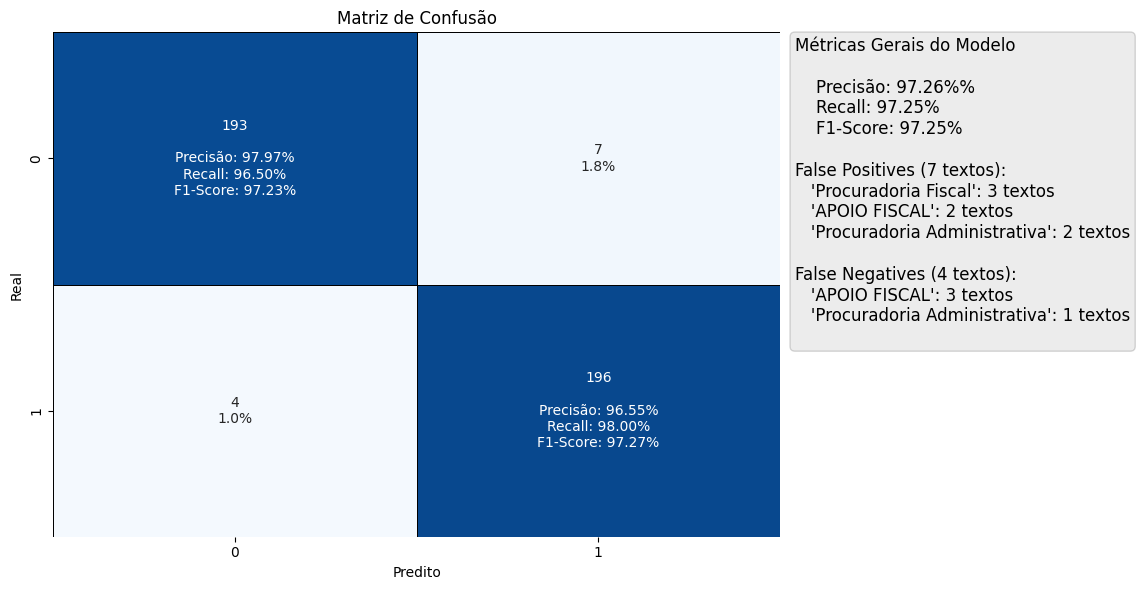

In [55]:
gs_best_estimator = search.best_estimator_
y_pred = gs_best_estimator.predict(X_val)

plot_classification_results(y_true=y_val, y_pred=y_pred)

### 5.3.2 - Fazendo CrossValidation no melhor modelo

In [86]:
modelos = [('SVM - Best Model', SVC(C=1, coef0=0.5, degree=4, kernel='poly'))]
transformacoes = [("TFIDF", ColumnTransformer([
        ("tfidf", TfidfVectorizer(max_features=3000, ngram_range=(1, 2)), "teorTexto")
    ], remainder="drop", sparse_threshold=0.0)),]

best_model_resultados_df = avaliar_modelos(df_clf_apoio_fiscal, y, modelos, transformacoes, n_splits=5)

TFIDF | SVM - Best Model: 100%|██████████| 5/5 [00:54<00:00, 10.84s/it]


In [87]:
best_model_resultados_df

,,Precisão,Acurácia,Recall,F1-Score,Tempo de Transf. e Treinamento
Transformação dos dados,Modelo,,,,,
TFIDF,SVM - Best Model,95.69% (+-0.63%),97.12% (+-0.34%),98.70% (+-0.19%),97.17% (+-0.33%),9.0s (+-0.1s)


# PEQUENO TESTE